# Initial Set Up

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from textblob import TextBlob
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [9]:
import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow_experiment_id = 260523122208174751

# Implementing a Model

In [3]:
def split_into_lemmas(message):
    message = message.lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

## Work on Training Data

In [4]:
train = pd.read_csv('Data/train.csv',
                       header=0)
train = train.dropna()

In [5]:
msg_train = train['content']
label_train = train['label']

- I choose to train a Support Vector Machine.
- I start by creating a pipeline and auto-tune over the training data to find the ideal hyper-parameters.

In [6]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(
        analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),
])

# pipeline parameters to automatically explore and tune
param_svm = [
  {'classifier__C': [1, 10, 100, 1000],
   'classifier__kernel': ['linear']
   },
  {'classifier__C': [1, 10, 100, 1000],
   'classifier__gamma': [0.001, 0.0001],
   'classifier__kernel': ['rbf']
   },
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(n_splits=10),  # what type of cross validation to use
)

svm_detectors = grid_svm.fit(msg_train, label_train) # find the best combination from param_svm

In [7]:
gscv_mean_acc = svm_detectors.cv_results_['mean_test_score']
gscv_std_acc = svm_detectors.cv_results_['std_test_score']
gscv_params = svm_detectors.cv_results_['params']

In [10]:
for i in range(len(gscv_params)):
    run_mean_acc = gscv_mean_acc[i]
    run_std_acc = gscv_std_acc[i]
    run_params = gscv_params[i]
    run_params = {key[len("classifier__"):] : run_params[key]
                  for key in run_params.keys()}
    
    with mlflow.start_run(experiment_id=mlflow_experiment_id):
        for param, value in run_params.items():
            mlflow.log_param(param, value)
        mlflow.log_metric("accuracy_mean", run_mean_acc)
        mlflow.log_metric("accuracy_std", run_std_acc)
        svc = SVC(**run_params)
        mlflow.sklearn.log_model(svc, "model")

/Users/sidshah/miniconda3/envs/aml-2024/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/sidshah/miniconda3/envs/aml-2024/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Now, the SVC with the following hyper-parameter has the highest accuracy:
- `C` $= 1$
- `kernel` : 'linear'

I proceed to train an SVC with these hyper-parameter values so that it can be used for making predications.

In [ ]:
bow_transformer = CountVectorizer(\
                        analyzer=split_into_lemmas)\
                    .fit(train['content'])
print(f'Transformer Vocabulary: {len(bow_transformer.vocabulary_)} words')

bow_train = bow_transformer.transform(msg_train)
tfidf_transformer = TfidfTransformer().fit(bow_train)
tfidf_train = tfidf_transformer.transform(bow_train)

Transformer Vocabulary: 29222 words


In [ ]:
spam_detector = SVC(kernel='linear',
                    C=1)\
                .fit(tfidf_train, label_train)

### Evaluation on Training Data

In [ ]:
pred_train = spam_detector.predict(tfidf_train)
print(f'Accuracy on Training Data: {int(10000 * \
                                        accuracy_score(label_train, pred_train))\
                                            / 100} %')

Accuracy on Training Data: 99.95 %


Text(0.5, 0, 'Predicted Label')

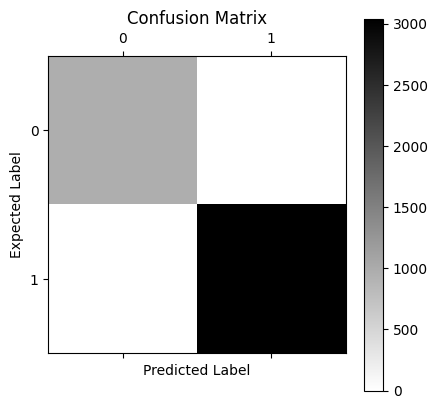

In [ ]:
plt.matshow(confusion_matrix(label_train, pred_train),
            cmap=plt.cm.binary,
            interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('Expected Label')
plt.xlabel('Predicted Label')

In [ ]:
print(classification_report(label_train, pred_train))

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00       966
        spam       1.00      1.00      1.00      3042

    accuracy                           1.00      4008
   macro avg       1.00      1.00      1.00      4008
weighted avg       1.00      1.00      1.00      4008



## Evaluation on Testing Data

In [ ]:
test = pd.read_csv('Data/test.csv', header=0)
test = test.dropna()
msg_test = test['content']
label_test = test['label']

In [ ]:
bow_test = bow_transformer.transform(msg_test)
tfidf_test = tfidf_transformer.transform(bow_test)

pred_test = spam_detector.predict(tfidf_test)
print(f'Accuracy on Testing Data: {int(10000 * \
                                        accuracy_score(label_test, pred_test))\
                                            / 100} %')

Accuracy on Testing Data: 99.47 %


Text(0.5, 0, 'Predicted Label')

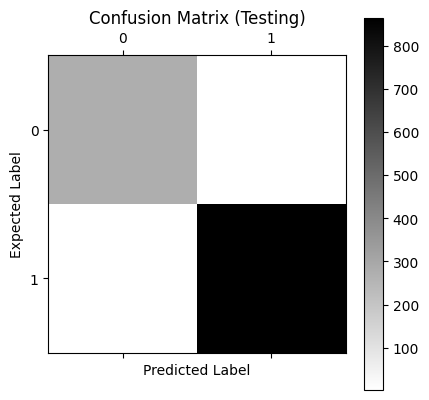

In [ ]:
plt.matshow(confusion_matrix(label_test, pred_test),
            cmap=plt.cm.binary,
            interpolation='nearest')
plt.title('Confusion Matrix (Testing)')
plt.colorbar()
plt.ylabel('Expected Label')
plt.xlabel('Predicted Label')

In [ ]:
print(classification_report(label_test, pred_test))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       279
        spam       1.00      1.00      1.00       866

    accuracy                           0.99      1145
   macro avg       0.99      0.99      0.99      1145
weighted avg       0.99      0.99      0.99      1145



## Evaluation on Validation Data

In [ ]:
val = pd.read_csv('Data/validation.csv', header=0)
val = val.dropna()
msg_val = val['content']
label_val = val['label']

In [ ]:
bow_val = bow_transformer.transform(msg_val)
tfidf_val = tfidf_transformer.transform(bow_val)

pred_val = spam_detector.predict(tfidf_val)
print(f'Accuracy on Testing Data: {int(10000 * \
                                        accuracy_score(label_val, pred_val))\
                                            / 100} %')

Accuracy on Testing Data: 99.29 %


Text(0.5, 0, 'Predicted Label')

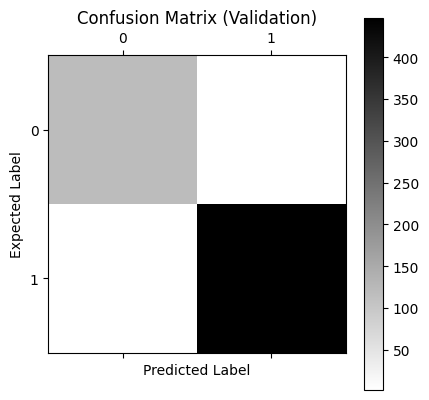

In [ ]:
plt.matshow(confusion_matrix(label_val, pred_val),
            cmap=plt.cm.binary,
            interpolation='nearest')
plt.title('Confusion Matrix (Validation)')
plt.colorbar()
plt.ylabel('Expected Label')
plt.xlabel('Predicted Label')

In [ ]:
print(classification_report(label_val, pred_val))

              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       122
        spam       1.00      1.00      1.00       449

    accuracy                           0.99       571
   macro avg       0.99      0.99      0.99       571
weighted avg       0.99      0.99      0.99       571

